In [1]:
%%HTML
<style>
.container { width:100% }
</style>

# A Backtracking Solver for CSPs

## Utility Functions

The module `extractVariables` implements the function $\texttt{extractVars}(e)$ that takes a *Python* expression $e$ as its argument and returns the set of all variables and function names occurring in $e$.

In [2]:
import extractVariables as ev

The function `collect_variables(expr)` takes a string `expr` that can be interpreted as a Python expression as input and collects all variables occurring in `expr`.  It takes care to eliminate the function symbols from the names returned by `extract_variables`.

In [3]:
def collect_variables(expr):
    return { var for var in ev.extractVars(expr)
                 if  var not in dir(__builtins__)
           }

In [4]:
ev.extractVars('abs(x - y) + abs(z1 - z2)')

{'abs', 'x', 'y', 'z1', 'z2'}

In [5]:
collect_variables('abs(x - y) + abs(z1 - z2)')

{'x', 'y', 'z1', 'z2'}

The function `arb(S)` takes a set `S` as input and returns an arbitrary element from 
this set.

In [6]:
def arb(S):
    "Return some element from the set S."
    for x in S:
        return x

Backtracking is simulated by raising the `Backtrack` exception.  We define this new class of exceptions so that we can distinguish `Backtrack` exceptions from ordinary exceptions.  This is done by creating a new, empty class that is derived from the class `Exception`.  

In [7]:
class Backtrack(Exception):
    pass

## The Backtracking Solver

The procedure `solve(P)` takes a a <b style="color:blue">constraint satisfaction problem</b> 
`P` as input.  Here `P` is a triple of the form 
$$ \mathcal{P} = \langle \mathtt{Variables}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
where 
- $\mathtt{Variables}$ is a set of strings which serve as <b style="color:blue">variables</b>,
- $\mathtt{Values}$ is a set of <b style="color:blue">values</b> that can be assigned 
  to the variables in the set $\mathtt{Variables}$.
- $\mathtt{Constraints}$ is a set of formulas from first order logic.  
  Each of these formulas is  called a <b style="color:blue">constraint</b> of $\mathcal{P}$.
  
The main purpose of the function `solve` is to convert the CSP `P` into an 
<b style="color:blue">augmented CSP</b> where every constraint $f$ is annotated with
the variables ocurring in $f$.  This annotates CSP is then solved using
`backtrack_search`.

In [13]:
def solve(P):
    Variables, Values, Constraints = P
    csp = (Variables, Values, [(f, collect_variables(f)) for f in Constraints])
    try:
        return backtrack_search({}, csp)
    except Backtrack:
        return None

The function `backtrack_search` takes two arguments:
- `Assignment` is a partial variable assignment that is represented as a dictionary.  Initially, this assignment will be the  empty dictionary.  Every recursive call of `backtrack_search` adds the assignment of one variable to  the given assignment. 
- `P` is an <b style="color:blue">augmented</b> constraint satisfaction problem, 
   i.e. `P` is a tripple of the form 
   $$ \mathcal{P} = \langle \mathtt{Vars}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
    where 
    - $\mathtt{Vars}$ is a set of strings which serve as <b style="color:blue">variables</b>,
    - $\mathtt{Values}$ is a set of <b style="color:blue">values</b> that can be assigned 
      to the variables in $\mathtt{Vars}$.
    - $\mathtt{Constraints}$ is a set of pairs of the form $(f, V)$ where $f$ is a Boolean Python 
      expression, while $V$ is the set of variables occuring in $f$.
The function `backtrack_search` tries to find a solution of `P` by recursively augmenting `Assignment`.

In [14]:
def backtrack_search(Assignment, P):
    print(Assignment) # useful to observe backtracking in action
    Variables, Values, Constraints = P
    if len(Assignment) == len(Variables):
        return Assignment
    var = arb(Variables - Assignment.keys())
    for value in Values:
        try:
            if is_consistent(var, value, Assignment, Constraints):
                NewAss = Assignment.copy()
                NewAss[var] = value
                return backtrack_search(NewAss, P)
        except Backtrack:
            continue
    raise Backtrack()  

The function $\texttt{is_consistent}(\texttt{var}, \texttt{value}, \texttt{Assignment}, \texttt{csp})$ takes four arguments:
<ol>
    <li>$\texttt{var}$ is a variable that does not occur in $\texttt{Assignment}$,</li>
    <li>$\texttt{value}$ is a value that can be substituted for this variable,</li>
    <li>$\texttt{Assignment}$ is a <b style="color:blue">consistent</b> partial variable assignment.         A partial variable assignment $A$ is <b style="color:blue">consistent</b> if all
        constraints $f$ that contain only variables from the set $\mathtt{dom}(A)$ are satisfied.
    <li>$\texttt{csp}$ is an <b style="color:blue">augmented</b> constraint satisfaction problem.</li>
</ol>
This function returns <tt>True</tt> iff the partial variable assignment 
$$\texttt{Assignment} \cup \{\langle\texttt{var} \mapsto\texttt{value}\rangle\}$$
is consistent with all the constraints occurring in $\texttt{csp}$.

In [15]:
def is_consistent(var, value, Assignment, Constraints):
    NewAssign      = Assignment.copy()
    NewAssign[var] = value
    return all(eval(f, NewAssign) for (f, Vs) in Constraints
                                  if  var in Vs and Vs <= NewAssign.keys()
              )

## Solving the *Eight-Queens-Puzzle*

In [16]:
%run N-Queens-Problem-CSP.ipynb

Variables:   {'V1', 'V3', 'V4', 'V2'}
Values:      {1, 2, 3, 4}
Constraints:
             abs(V3 - V1) != 2
             V1 != V2
             abs(V4 - V3) != 1
             abs(V3 - V2) != 1
             abs(V4 - V2) != 2
             abs(V2 - V1) != 1
             abs(V4 - V1) != 3
             V1 != V4
             V3 != V4
             V2 != V3
             V2 != V4
             V1 != V3


In [17]:
P = create_csp(8)

Backtracking search takes about 10 milliseconds on my desktop to solve the eight queens puzzle.

In [18]:
%%time
Solution = solve(P)
print(f'Solution = {Solution}')

{}
{'V7': 1}
{'V7': 1, 'V4': 2}
{'V7': 1, 'V4': 2, 'V8': 3}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5, 'V5': 4}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5, 'V5': 4, 'V6': 6}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5, 'V5': 4, 'V6': 6, 'V3': 7}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5, 'V5': 4, 'V6': 7}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5, 'V5': 4, 'V6': 8}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5, 'V5': 4, 'V6': 8, 'V3': 7}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 5, 'V5': 7}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 7}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 7, 'V5': 5}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 7, 'V5': 5, 'V6': 8}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 7, 'V5': 5, 'V6': 8, 'V3': 4}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 7, 'V5': 8}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 7, 'V5': 8, 'V6': 6}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 7, 'V5': 8, 'V6': 6, 'V3': 4}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 8}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 8, 'V5': 4}
{'V7': 1, 'V4': 2, 'V8': 3, 'V2': 8, 'V5': 4, 'V6': 6}
{'V7': 1, 'V4

## Displaying the Solution

In order to have a more convenient view of the solution of the 8 queens
puzzle, we have to install `python-chess`.  After activating the appropriate  Python environment, this can be done using the following command:
```
   pip install python-chess
```

In [19]:
import chess

The function `show_solution(Solution)` takes a dictionary that contains a variable assignment that represents a solution to the 8-queens puzzle.  It displays this Solution on a chess board.

In [20]:
def show_solution(Solution):
    board = chess.Board(None)  # create empty chess board
    queen = chess.Piece(chess.QUEEN, True)
    for row in range(1, 8+1):
        col = Solution['V'+str(row)]
        field_number = (row - 1) * 8 + col - 1
        board.set_piece_at(field_number, queen)
    display(board)

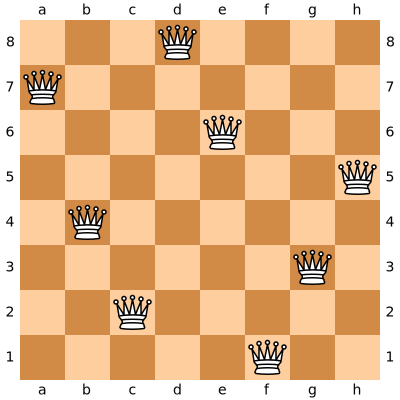

In [21]:
show_solution(Solution)

## Solving the *Zebra Puzzle*

In [ ]:
%run Zebra.ipynb

In [ ]:
zebra = zebra_csp()

In [ ]:
%%time
Solution = solve(zebra)

In [ ]:
show_solution(Solution)